# Pipeline to remove Camponotus planatus (Cpla) contamination from Odontomachus ruginodis (Orug) transcriptome
This takes single gene phylogenies as input, along with the transcriptomes and other stuff

## Table of Contents

1. Find genes in Orug that have >90% blast similarity to a gene in Cpla
2. Find their peptide sequences (MAGGGOT), find their best hit in 11 other Apoidea (BLASTP), align (MAFFT), and build ML phylogenies (RAxML)
3. Read in trees and analyse
4. Construct dataframe with sequence and phylogenetic features
5. Plots showing that these features indicate contamination
6. Identify and remove contaminants from the transcriptome
7. Remove contaminant sequences from the htseq counts files

In [1]:
############ cd /Users/vchandra/Desktop/alignm/biopython_test/

/Users/vchandra/Desktop/alignm/biopython_test


In [1]:
import sys
sys.executable

'/Users/poxley/anaconda3/envs/bioinformatics/bin/python'

In [2]:
#import libraries
#from Bio.Seq import Seq
from Bio import SeqIO
#from Bio.Alphabet import IUPAC
#from __future__ import division
import os
#import math
from ete3 import Tree

In [3]:
import numpy as np
import pandas as pd

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Find genes in Orug that have >90% blast similarity to a gene in Cpla

In [9]:
blast_cols = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']

#Read in blast output table of whole Orug transcriptome blastp'd against whole Cpla transcriptome
df_Orug_vs_Cpla = pd.read_csv(os.path.join("contamination_assessment","Orug_vs_Cpla.txt"), 
                              header=None,
                              sep='\t',
                              names=blast_cols,
                             )
df_Orug_vs_Cpla.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,Orug|SGF62645,Cpla|SGF49990,100.00,104,0,0,1,104,517,620,5.000000e-68,219.0
1,Orug|SGF62647,Cpla|SGF48983,100.00,15,0,0,105,119,22,36,2.000000e-03,35.0
2,Orug|SGF62648,Cpla|SGF59801,86.18,340,13,3,1,308,23,360,0.000000e+00,545.0
3,Orug|SGF62649,Cpla|SGF51865,29.41,68,42,1,48,115,96,157,4.700000e+00,25.8
4,Orug|SGF65438,Cpla|SGF57541,27.63,76,55,0,45,120,2964,3039,2.100000e+00,27.3


In [10]:
#find Orug genes with >90% identity to Cpla
genes_for_tree = df_Orug_vs_Cpla[df_Orug_vs_Cpla.pident > 90]['qseqid'].values

print('{} Orug genes with >90% identity to their best hit in Cpla.'.format(len(genes_for_tree)))

3522 Orug genes with >90% identity to their best hit in Cpla.


### 2. Find their peptide sequences (MAGGGOT), find their best hit in 11 other Apoidea (BLASTP), align (MAFFT), and build ML phylogenies (RAxML)

In [11]:
#make series with list of candidate Orug genes
s_Orug_genes = pd.Series(genes_for_tree, name='Genes' )
s_Orug_genes.head()

0    Orug|SGF62645
1    Orug|SGF62647
2    Orug|SGF62652
3    Orug|SGF62674
4    Orug|SGF62679
Name: Genes, dtype: object

In [6]:
#############cd Orug

/Users/vchandra/Desktop/alignm/biopython_test/Orug


In [14]:
# create dictionary of blast results
sp_list = ['Aech', 'Amel', 'Bimp', 'Cpla', 'Cflo', 'Dqua', 'Hsal', 'Lnig', 'Mrot', 'Obir', 'Sinv']
fp_list = ["contam_Orug_vs_{}.bx".format(x) for x in sp_list ]
           
sp_blast = { sp:pd.read_csv(os.path.join("contamination_assessment",fp), 
                            header=None, 
                            names=blast_cols,
                            sep='\t',
                           ) for sp,fp in zip(sp_list, fp_list)}

In [15]:
sp_blast['Amel'].head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,Orug|SGF62645,Amel|LOC411540,98.08,104,2,0,1,104,517,620,8.000000e-67,215.0
1,Orug|SGF62647,Amel|LOC411273,32.43,37,25,0,47,83,199,235,3.000000e+00,26.9
2,Orug|SGF62652,Amel|LOC551967,87.42,310,38,1,1,310,1,309,0.000000e+00,571.0
3,Orug|SGF62674,Amel|Iscu,86.13,137,19,0,14,150,14,150,1.000000e-84,248.0
4,Orug|SGF62679,Amel|LKR,80.50,200,39,0,1,200,719,918,2.000000e-109,336.0


In [9]:
Orug_hits = {}
for i in sp_list:
    for ind, row in i.iterrows():
        if row['evalue'] < 0.01:
            if row['qseqid'] in Orug_hits.keys():
                Orug_hits[row['qseqid']].append(row['sseqid'])
            else:
                Orug_hits[row['qseqid']] = [row['sseqid']]


In [10]:
#include Orug gene in list
for key in Orug_hits.keys():
    Orug_hits[key].append(key)

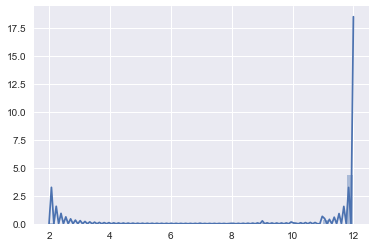

In [11]:
vals = []
for i in Orug_hits.values():
    vals.append(len(i))

sns.distplot(vals)

In [17]:
#save lists of Orug orthologue groups; one group per file
for key in Orug_hits.keys():
    newfile = open(key+'.out', 'w')
    for value in Orug_hits[key]:
        newfile.write('%s\n' % value) 

Used mafft and raxml on the server to construct phylogenies for each of these orthologue groups (scripts attached below); analysis continues here. 


#MAGGGOT Script

#!/usr/bin/bash

for i in $(cat 'Orug_candidate_seqs.txt'); do 

MAGOT get_seq_from_fasta '../Orug_trinity.pep' $i True >> Orug_candidate_seqs.fasta 

done


#MAFFT Script

#!/usr/bin/bash

for i in $(ls '/home/antqueen/booster/VC20170918_txome_check/blast_dir/Orug_candidates/Orug_sequences/'); do

mafft --localpair --thread 30 --maxiterate 1000 /home/antqueen/booster/VC20170918_txome_check/blast_dir/Orug_candidates/Orug_sequences/$i > $i.aligned

done


#RAxML Script

#!/usr/bin/bash

for i in $(ls '/home/antqueen/booster/VC20170918_txome_check/blast_dir/Orug_candidates/alignments/'); do

/home/sean/tools/RAxML/raxml -s /home/antqueen/booster/VC20170918_txome_check/blast_dir/Orug_candidates/alignments/$i -m PROTGAMMAJTT -p 6666 -T 30 -n $i.out 

done

### 3. Read in trees and analyse

In [16]:
#list all Orug trees in treelist
treelist = []
for file in os.listdir('/Users/vchandra/Desktop/alignm/biopython_test/Orug/Orug_trees/'):
    if 'bestTree' in file:
        treelist.append(file)

print(len(treelist))

3469


In [18]:
cd Orug_trees/

/Users/vchandra/Desktop/alignm/biopython_test/Orug/Orug_trees


In [19]:
#print examples of these phylogenies
for i in range(0, 2):
    x = Tree(treelist[i])
    print(x)


         /-Cbir|LOC105285907
        |
      /-|      /-Cpla|SGF56824
     |  |   /-|
     |  |  |   \-Cflo|XP_011260747.1
     |   \-|
   /-|     |   /-Orug|SGF66875
  |  |      \-|
  |  |         \-KMQ93665.1
  |  |
  |  |   /-Sinv|XP_011159147.1
  |   \-|
  |     |   /-Dqua|LOC106746720
  |      \-|
--|         \-Hsal|LOC105187517
  |
  |   /-Mrot|XP_003706718.1
  |--|
  |  |   /-Bimp|XP_003487350.1
  |   \-|
  |      \-Amel|LOC408372
  |
   \-Aech|XP_011062839.1

   /-Sinv|XP_011169572.1
  |
  |      /-Cbir|LOC105275518
  |     |
  |   /-|   /-Dqua|LOC106742533
  |  |  |  |
  |  |   \-|      /-Orug|SGF64046
  |  |     |   /-|
  |  |      \-|   \-Cpla|SGF48456
  |--|        |
  |  |         \-Hsal|LOC105191572
--|  |
  |  |   /-KMQ96987.1
  |  |  |
  |  |  |         /-Bimp|XP_003488371.1
  |   \-|      /-|
  |     |   /-|   \-Mrot|XP_003706904.1
  |     |  |  |
  |      \-|   \-Amel|LOC550651
  |        |
  |         \-Cflo|XP_011258337.1
  |
   \-Aech|XP_011066661.1


In [20]:
# for each tree in the list, ask whether Cpla is sister to Orug. 
# store names of possible contaminant sequences
# store distances between Orug and Cpla in separate files; one for good trees and one for possible contaminants
# plot distributions of these distances

contaminants = {}
good_genes = {}
s_clade = {}
bee_tree_errors = []
no_bees = []
weird_bees = []
s_clade_errors = []
bee_seq_errors = []
scl1 = 0
nobiroi = []
fail = []
sis_clade_fail = []


for tree in treelist:
    Cpla = ''
    Orug = ''
    Cflo = ''
    Lnig = ''
    Hsal = ''
    Dqua = ''
    Mrot = ''
    Amel = ''
    Bimp = ''
    x = ''
    sis_clade = ''
    bee_ancestor = []
    bad = False

    intree = Tree(tree)
    for leaf in intree: 
        if 'Mrot' in leaf.name:
            Mrot = leaf.name
        elif 'Amel' in leaf.name:
            Amel = leaf.name
        elif 'Bimp' in leaf.name:
            Bimp = leaf.name
        elif 'Cbir' in leaf.name:
            Obir = leaf.name
    
    #find bees
    nbees = []
    for i in [Mrot, Amel, Bimp]:
        if i != '':
            nbees.append(i)
    
    #find ancestor of all bees
    try:
        if len(nbees) > 1:
            bee_ancestor = intree.get_common_ancestor(nbees)
        elif len(nbees) == 1:
            bee_ancestor = [nbees[0]]
        else:
            no_bees.append(tree)
    except:
        bee_seq_errors.append(tree)
        continue
    
    #reroot tree on ancestral bee (allow bee clade to contain up to one non-bee and if not, try rooting on any one bee. 
    # If this also fails, try rooting on biroi. Catch exceptions in nobiroi and go to next tree)
    if len(bee_ancestor) <= 4 and len(bee_ancestor) > 1:
        intree.set_outgroup(bee_ancestor)
    elif len(bee_ancestor) > 4 or len(bee_ancestor) == 1:
        intree.set_outgroup(nbees[0])
        weird_bees.append(tree)
    elif len(bee_ancestor) == 0:
        try:
            intree.set_outgroup(Obir)
        except:
            nobiroi.append(tree)
            bad = True
    
    if not bad:
        for leaf in intree:
            if 'Cpla' in leaf.name:
                Cpla = leaf.name
            elif 'Orug' in leaf.name:
                Orug = leaf.name
            elif 'Hsal' in leaf.name:
                Hsal = leaf.name
            elif 'KM' in leaf.name:
                Lnig = leaf.name
            elif 'Dqua' in leaf.name:
                Dqua = leaf.name
            elif 'Cflo' in leaf.name:
                Cflo = leaf.name
                
                

        if len(Cpla) > 0: 
            x = str(tree)
            x = x.split('.')
            x = x[1]
            cont_check = intree.get_common_ancestor(Cpla, Orug)
            if len(cont_check) == 2:
                contaminants[x] = intree.get_distance(Cpla, Orug)
            elif len(cont_check) > 2:
                good_genes[x] = intree.get_distance(Cpla, Orug)
            sis_clade = cont_check.get_sisters()
            
            if sis_clade != '':
                if Lnig != '' and Cflo != '' and Dqua != '' and Hsal != '':
                    Hmrca = intree.get_common_ancestor(cont_check, Hsal)
                    Dmrca = intree.get_common_ancestor(cont_check, Dqua)
                    Cmrca = intree.get_common_ancestor(cont_check, Cflo)
                    Lmrca = intree.get_common_ancestor(cont_check, Lnig)
                    Pav = min(len(Hmrca), len(Dmrca))
                    Fav = min(len(Cmrca), len(Lmrca))
                
                    #check if Orug is in ponerine or formicine clade
                    if len(sis_clade) == 1:
                        if Pav > Fav:
                            s_clade[x] = 'F'
                        elif Pav < Fav:
                            s_clade[x] = 'P'
                        else:
                            if len(cont_check) == 2:
                                s_clade[x] = 'both'
                                sis_clade_fail.append(tree)
                        scl1 += 1
                else: 
                    s_clade_errors.append(x)    
                
            
    else: 
        fail.append(tree)
    


In [21]:
print('Trees with no bees and no O. biroi sequences: ' + str(len(nobiroi)))
print('failures: ' + str(len(fail)))
print('Trees with no bees: ' + str(len(no_bees)))
print('Possible contaminants: ' + str(len(contaminants)))
print('Good genes: ' + str(len(good_genes)))
print('Successful classification of clade: ' + str(len(s_clade)))
print('Bee sequence errors: ' + str(len(bee_seq_errors)))
print('Bee tree errors: ' + str(len(bee_tree_errors)))
print('Weird bees: ' + str(len(weird_bees)))
print('Clade classification errors: ' + str(len(s_clade_errors)))
print(scl1)
print(len(sis_clade_fail))

Trees with no bees and no O. biroi sequences: 5
failures: 5
Trees with no bees: 43
Possible contaminants: 522
Good genes: 2940
Successful classification of clade: 805
Bee sequence errors: 0
Bee tree errors: 0
Weird bees: 330
Clade classification errors: 253
3184
10


In [22]:
#define true species tree
truetree = Tree("(((Dqua,(Orug, Hsal)),(Obir,((Lnig,(Cflo, Cpla)),(Aech, Sinv)))),(Mrot, (Amel, Bimp)));")

#make dictionary with Robinson-Foulds distances between each tree and the true species tree

rfs = {}
bee_tree_errors2 = []
bee_seq_errors2 = []

for tree in treelist:
    Cpla = []
    Orug = []
    Cflo = []
    Lnig = []
    Hsal = []
    Dqua = []
    Obir = []
    Amel = []
    Mrot = []
    Bimp = []
    Sinv = []
    Aech = []

    intree = Tree(tree)
    for leaf in intree: 
        if 'Mrot' in leaf.name:
            Mrot = leaf.name
        elif 'Amel' in leaf.name:
            Amel = leaf.name
        elif 'Bimp' in leaf.name:
            Bimp = leaf.name
        elif 'Orug' in leaf.name:
            Orug = leaf.name
   
    nbees = []
    for i in [Mrot, Amel, Bimp]:
        if i != '':
            nbees.append(i)
    
    try:
        bee_ancestor = intree.get_common_ancestor(nbees)
    except:
        bee_seq_errors2.append(tree)
        continue
        
    if len(bee_ancestor) <= 4 and len(bee_ancestor) > 0:
        intree.set_outgroup(bee_ancestor)
    else:
        bee_tree_errors2.append(tree)
    
    if len(bee_ancestor) <= 4 and len(bee_ancestor) > 0:
        for leaf in intree:
            if 'Cpla' in leaf.name:
                leaf.name = 'Cpla'
            elif 'Orug' in leaf.name:
                leaf.name = 'Orug'
            elif 'Hsal' in leaf.name:
                leaf.name = 'Hsal'
            elif 'KM' in leaf.name:
                leaf.name = 'Lnig'
            elif 'Dqua' in leaf.name:
                leaf.name = 'Dqua'
            elif 'Cflo' in leaf.name:
                leaf.name = 'Cflo'
            elif 'Cbir' in leaf.name:
                leaf.name = 'Obir'
            elif 'Aech' in leaf.name:
                leaf.name = 'Aech'
            elif 'Sinv' in leaf.name:
                leaf.name = 'Sinv'
            elif 'Amel' in leaf.name:
                leaf.name = 'Amel'
            elif 'Bimp' in leaf.name:
                leaf.name = 'Bimp'
            elif 'Mrot' in leaf.name:
                leaf.name = 'Mrot'
        
        a = truetree.robinson_foulds(intree)
        normrf = float(a[0])/float(a[1])
        rfs[Orug] = float(normrf)

In [23]:
print(len(rfs))

2993


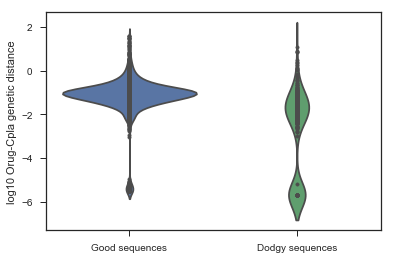

In [24]:
#plot tree distance for good sequences and potential contaminants (i.e. dodgy sequences)
sns.set_style('ticks')

lgd = []
lbd = []

for x in good_genes.values():
    lgd.append(np.log10(x)) 
    
for x in contaminants.values():
    lbd.append(np.log10(x))
    
aa = sns.violinplot(data = [lgd, lbd], scale = 'count', inner = 'point')
aa.set(ylabel = 'log10 Orug-Cpla genetic distance')
aa.set_xticklabels(['Good sequences', 'Dodgy sequences'])

In [25]:
#run before making genes DataFrame
os.chdir('/Users/vchandra/Desktop/alignm/biopython_test/')


### 4. Construct dataframe with sequence and phylogenetic features

In [26]:
#read in outputs for blastp of Orug against Cpla and two formicines
Orug_vs_Cpla = open("Orug_vs_Cpla", 'r')
Orug_vs_Cpla = pd.read_table(Orug_vs_Cpla, header = None)
Orug_vs_Cpla.columns = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']

Orug_vs_Lnig = open("Orug_vs_Lnig.bx", 'r')
Orug_vs_Lnig = pd.read_table(Orug_vs_Lnig, header = None)
Orug_vs_Lnig.columns = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']

Orug_vs_Cflo = open("Orug_vs_Cflo.bx", 'r')
Orug_vs_Cflo = pd.read_table(Orug_vs_Cflo, header = None)
Orug_vs_Cflo.columns = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']

In [27]:
Orug_vs_Cpla.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,Orug|SGF62645,Cpla|SGF49990,100.00,104,0,0,1,104,517,620,5.000000e-68,219.0
1,Orug|SGF62647,Cpla|SGF48983,100.00,15,0,0,105,119,22,36,2.000000e-03,35.0
2,Orug|SGF62648,Cpla|SGF59801,86.18,340,13,3,1,308,23,360,0.000000e+00,545.0
3,Orug|SGF62649,Cpla|SGF51865,29.41,68,42,1,48,115,96,157,4.700000e+00,25.8
4,Orug|SGF65438,Cpla|SGF57541,27.63,76,55,0,45,120,2964,3039,2.100000e+00,27.3


In [28]:
Cpla_deseq = open('/Users/vchandra/Desktop/Camp_planatus.genes.QW.pvalues.nohed.out', 'r')
Cpla_deseq = pd.read_csv(Cpla_deseq, sep = ' ', names = ['genes', 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj'])

Orug_deseq = open('/Users/vchandra/Desktop/Odontomachus.genes.QW.pvalues.nohed.out', 'r')
Orug_deseq = pd.read_csv(Orug_deseq, sep = ' ', names = ['genes', 'baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj'])
Orug_deseq.head()

,genes,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,Orug|SGF82787,2400.887711,-2.557067,0.168923,-15.137451,9.169985e-52,1.387602e-47
1,Orug|SGF63944,600.445549,-3.010519,0.215700,-13.956944,2.854124e-44,2.159430e-40
2,Orug|SGF61220,2092.490625,-2.957865,0.213546,-13.851192,1.251180e-43,6.310950e-40
3,Orug|SGF64259,761.007066,-3.751297,0.274955,-13.643294,2.213327e-42,8.373017e-39
4,Orug|SGF68061,194.643827,-2.377130,0.175826,-13.519819,1.194690e-41,3.031041e-38


In [29]:
#create a massive dataframe of good and bad Cpla genes with >90% pident to Orug
genes = pd.read_table('Orug_candidates.txt', header = None)
genes.columns = ['Orug_genes']
genes['Orug_length'] = ''
genes['Cpla_genes'] = ''
genes['Cpla_length'] = ''
genes['pident_vs_Cpla'] = ''               #Cpla blast pident against Cpla
genes['pident_vs_Lnig'] = ''               #Orug blast pident against Lnig
genes['pident_vs_Cflo'] = ''               #Cpla blast pident against Cflo      
genes['normpident'] = ''
genes['genetic_distance'] = ''
genes['Orug_expressionlevel'] = ''
genes['Cpla_expressionlevel'] = ''
genes['len_diff'] = ''
genes['exp_diff'] = ''
genes['contaminated'] = ''
genes['dist_classification'] = ''
genes['class'] = ''
genes['ctd_sis_taxon'] = ''
genes['rfdist'] = ''
genes.head()

,Orug_genes,Orug_length,Cpla_genes,Cpla_length,pident_vs_Cpla,pident_vs_Lnig,pident_vs_Cflo,normpident,genetic_distance,Orug_expressionlevel,Cpla_expressionlevel,len_diff,exp_diff,contaminated,dist_classification,class,ctd_sis_taxon,rfdist
0,Orug|SGF62645,,,,,,,,,,,,,,,,,
1,Orug|SGF62647,,,,,,,,,,,,,,,,,
2,Orug|SGF62652,,,,,,,,,,,,,,,,,
3,Orug|SGF62674,,,,,,,,,,,,,,,,,
4,Orug|SGF62679,,,,,,,,,,,,,,,,,


In [30]:
#find lengths of each peptide sequence in the Orug and Cpla transcriptomes; save in dictionaries
Cpla_records = list(SeqIO.parse('Cpla_trinity.pep', 'fasta'))
Orug_records = list(SeqIO.parse('Orug_trinity.pep', 'fasta'))
Cpla_txome = {}
Orug_txome = {}

for record in Cpla_records:
    Cpla_txome[str(record.name)] = str(record.seq)
    
for record in Orug_records: 
    Orug_txome[str(record.name)] = str(record.seq)
    
Cpla_lengths = {}
Orug_lengths = {}

for seq in Cpla_txome.keys():
    Cpla_lengths[seq] = len(Cpla_txome[seq])
    
for seq in Orug_txome.keys():
    Orug_lengths[seq] = len(Orug_txome[seq])


In [31]:
#begin populating the massive dataframe
    
pidents_vs_Cpla = {}       #used to be vs Orug
pidents_vs_Lnig = {}       #used to be vs Hsal
pidents_vs_Cflo = {}       #used to be vs Dqua
Cpla_genes = {}            #used to be Orug_genes

for ind, row in Orug_vs_Cpla.iterrows():
    pidents_vs_Cpla[row['qseqid']] = row['pident']
    Cpla_genes[row['qseqid']] = row['sseqid']

for ind, row in Orug_vs_Cflo.iterrows():
    pidents_vs_Cflo[row['qseqid']] = row['pident']
    
for ind, row in Orug_vs_Lnig.iterrows():
    pidents_vs_Lnig[row['qseqid']] = row['pident']

for ind, row in genes.iterrows():
    if row['Orug_genes'] in Orug_lengths.keys() and row['Orug_genes'] in pidents_vs_Cpla.keys():
        row['Orug_length'] = Orug_lengths[row['Orug_genes']]
        row['pident_vs_Cpla'] = pidents_vs_Cpla[row['Orug_genes']]
        row['Cpla_genes'] = Cpla_genes[row['Orug_genes']]
    if row['Orug_genes'] in pidents_vs_Cflo.keys() and row['Orug_genes'] in pidents_vs_Lnig.keys():
        row['pident_vs_Cflo'] = pidents_vs_Cflo[row['Orug_genes']]
        row['pident_vs_Lnig'] = pidents_vs_Lnig[row['Orug_genes']]
        
for ind, row in genes.iterrows():
    if row['Cpla_genes'] != '':
        row['Cpla_length'] = Cpla_lengths[row['Cpla_genes']]
        
    


In [32]:
genes.head()

,Orug_genes,Orug_length,Cpla_genes,Cpla_length,pident_vs_Cpla,pident_vs_Lnig,pident_vs_Cflo,normpident,genetic_distance,Orug_expressionlevel,Cpla_expressionlevel,len_diff,exp_diff,contaminated,dist_classification,class,ctd_sis_taxon,rfdist
0,Orug|SGF62645,104,Cpla|SGF49990,795,100,87.07,99.04,,,,,,,,,,,
1,Orug|SGF62647,143,Cpla|SGF48983,108,100,34.38,34.09,,,,,,,,,,,
2,Orug|SGF62652,313,Cpla|SGF65473,220,96.36,40.08,95.81,,,,,,,,,,,
3,Orug|SGF62674,161,Cpla|SGF48204,154,100,88.54,87.5,,,,,,,,,,,
4,Orug|SGF62679,201,Cpla|SGF63546,939,90.55,90,89.5,,,,,,,,,,,


In [33]:
#make dictionaries of basemean expression values
Cpla_deseq_basemean = {}
Orug_deseq_basemean = {}
for ind, row in Cpla_deseq.iterrows():
    Cpla_deseq_basemean[row['genes']] = row['baseMean']

for ind, row in Orug_deseq.iterrows():
    Orug_deseq_basemean[row['genes']] = row['baseMean']
    

In [34]:
#continue populating massive dataframe

keyerrors = []
keyerrors2 = []

for ind, row in genes.iterrows():
    if row['Orug_genes'] in contaminants.keys():
        row['genetic_distance'] = contaminants[row['Orug_genes']]
        row['contaminated'] = 1
            
    elif row['Orug_genes'] in good_genes.keys():
        row['genetic_distance'] = good_genes[row['Orug_genes']]
        row['contaminated'] = 0
        row['class'] = 'Good'
           
    else:
        keyerrors.append(row['Orug_genes'])

for ind, row in genes.iterrows():
    if row['Cpla_genes'] in Cpla_deseq_basemean.keys():
        row['Cpla_expressionlevel'] = Cpla_deseq_basemean[row['Cpla_genes']]
        
    if row['Orug_genes'] in Orug_deseq_basemean.keys():
        row['Orug_expressionlevel'] = Orug_deseq_basemean[row['Orug_genes']]
        
    if row['Orug_genes'] in rfs.keys():
        row['rfdist'] = rfs[row['Orug_genes']]

        
for ind, row in genes.iterrows():
    if row['pident_vs_Lnig'] != '' and row['pident_vs_Cflo'] != '' and row['pident_vs_Cpla'] != '':
        row['normpident'] = (float(row['pident_vs_Cpla'])/((float(row['pident_vs_Cflo']) + float(row['pident_vs_Lnig']) / 2)))
                            
    if row['genetic_distance'] == '':
        keyerrors2.append(row['Orug_genes'])
    else:    
        x = float(row['genetic_distance'])
        if np.log10(x) >= -4:
            row['dist_classification'] = 0
        elif np.log10(x) < -4:
            row['dist_classification'] = 1
            
for ind, row in genes.iterrows():
    if row['genetic_distance'] == '':
        row['genetic_distance'] = float('nan')
    
    if row['contaminated'] == '':
        row['contaminated'] = float('nan')
        
    if row['pident_vs_Cpla'] == '':
        row['pident_vs_Cpla'] = float('nan')
        
    if row['Cpla_expressionlevel'] == '':
        row['Cpla_expressionlevel'] = float('nan')

    if row['Orug_expressionlevel'] == '' or row['Orug_expressionlevel'] == 0:
        row['Orug_expressionlevel'] = float('nan')

    if row['dist_classification'] == '':
        row['dist_classification'] = float('nan')
        
    if row['rfdist'] == '':
        row['rfdist'] = float('nan')
        
        

In [35]:
#add in len_diff, exp_diff, sis_taxon
keyerrors3 = []

for ind, row in genes.iterrows():
    if row['Cpla_length'] == '' or row['Orug_length'] == '':
        keyerrors3.append(row['Orug_genes'])
    else:
        row['len_diff'] = (row['Orug_length'] - row['Cpla_length']) / (row['Cpla_length'] + row['Orug_length'])
        row['exp_diff'] = (row['Orug_expressionlevel'] - row['Cpla_expressionlevel']) / (row['Cpla_expressionlevel'] + row['Orug_expressionlevel'])

for ind, row in genes.iterrows():
    if row['Orug_genes'] in s_clade.keys():
        row['ctd_sis_taxon'] = s_clade[row['Orug_genes']]

#only label genes 'bad' if they are in the ponerine clade
for ind, row in genes.iterrows():
    if row['contaminated'] == 1 and (row['ctd_sis_taxon'] == 'P'):
        row['class'] = 'Guilty'
    elif row['contaminated'] == 1 and (row['ctd_sis_taxon'] == 'F' or row['ctd_sis_taxon'] == 'both'):
        row['class'] = 'Bad'

In [36]:
genes.head()

,Orug_genes,Orug_length,Cpla_genes,Cpla_length,pident_vs_Cpla,pident_vs_Lnig,pident_vs_Cflo,normpident,genetic_distance,Orug_expressionlevel,Cpla_expressionlevel,len_diff,exp_diff,contaminated,dist_classification,class,ctd_sis_taxon,rfdist
0,Orug|SGF62645,104,Cpla|SGF49990,795,100,87.07,99.04,0.701385,2.09467e-06,0.243665,1477.91,-0.768632,-0.99967,1,1,Bad,F,0.7
1,Orug|SGF62647,143,Cpla|SGF48983,108,100,34.38,34.09,1.95008,NaN,62.4456,0.752753,0.139442,0.976178,NaN,NaN,,,NaN
2,Orug|SGF62652,313,Cpla|SGF65473,220,96.36,40.08,95.81,0.831765,0.132791,5.27706,0.745316,0.174484,0.752484,0,0,Good,,0.7
3,Orug|SGF62674,161,Cpla|SGF48204,154,100,88.54,87.5,0.758898,2.09467e-06,6506.63,2.9347,0.0222222,0.999098,1,1,Guilty,P,0.7
4,Orug|SGF62679,201,Cpla|SGF63546,939,90.55,90,89.5,0.673234,0.107483,0.163538,10.3042,-0.647368,-0.968754,0,0,Good,,0.2


### 5. Plots showing that these features indicate contamination
The plots below show clearly that the phylogenetic classification identifies genes in Orug that have low expression, are very short, and have very low genetic distance to their best hit in Cpla. 
Moreover, the phylogenetic classification of the parent/sister clade of these likely contaminants adds confidence to this classification. 

In [37]:
#CONTAMINATION PLOTS

#classify by tree
good_Cexp = []
good_Oexp = []
good_pident = []
good_length = []
bad_Cexp = []
bad_Oexp = []
bad_pident = []
bad_length = []
good_ldiff = []
bad_ldiff = []
good_expdiff = []
bad_expdiff = []

for ind, row in genes.iterrows():
    if row['contaminated'] == 0:
        good_Cexp.append(np.log10(row['Cpla_expressionlevel']))
        good_Oexp.append(np.log10(row['Orug_expressionlevel']))
        good_pident.append(np.log10(row['pident_vs_Cpla']))
        good_length.append(np.log10(row['Orug_length']))
        good_ldiff.append(row['len_diff'])
        good_expdiff.append(row['exp_diff'])
    elif row['contaminated'] == 1:
        bad_Cexp.append(np.log10(row['Cpla_expressionlevel']))
        bad_Oexp.append(np.log10(row['Orug_expressionlevel']))
        bad_pident.append(np.log10(row['pident_vs_Cpla']))
        bad_length.append(np.log10(row['Orug_length']))
        bad_ldiff.append(row['len_diff'])
        bad_expdiff.append(row['exp_diff'])


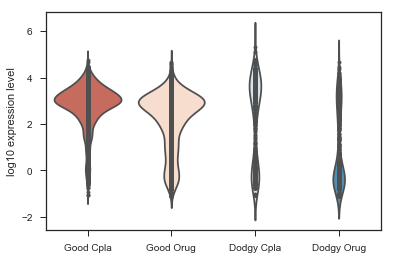

In [38]:
ax = sns.violinplot(data = [good_Cexp, good_Oexp, bad_Cexp, bad_Oexp], scale = 'count', inner = 'point', palette='RdBu')
ax.set(ylabel = 'log10 expression level')
ax.set_xticklabels(['Good Cpla', 'Good Orug', 'Dodgy Cpla', 'Dodgy Orug'])
ax = sns.set_style('ticks')

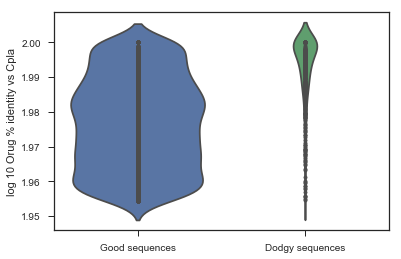

In [39]:
ax2 = sns.violinplot(data = [good_pident, bad_pident], scale = 'count', inner = 'point')
ax2.set(ylabel = 'log 10 Orug % identity vs Cpla')
ax2.set_xticklabels(['Good sequences', 'Dodgy sequences'])
ax2 = sns.set_style('ticks')

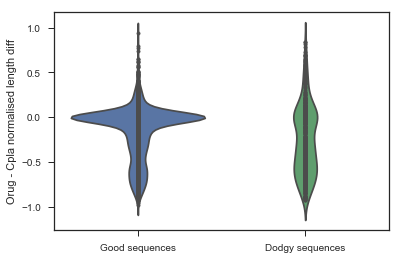

In [40]:
ax7 = sns.violinplot(data = [good_ldiff, bad_ldiff], scale = 'count', inner = 'point')
ax7.set(ylabel = 'Orug - Cpla normalised length diff')
ax7.set_xticklabels(['Good sequences', 'Dodgy sequences'])
ax7 = sns.set_style('ticks')

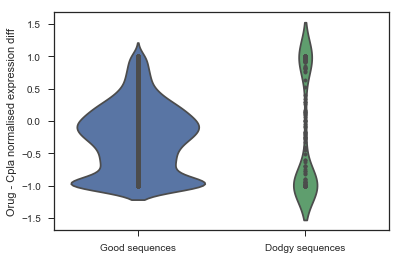

In [41]:
ax8 = sns.violinplot(data = [good_expdiff, bad_expdiff], scale = 'count', inner = 'point')
ax8.set(ylabel = 'Orug - Cpla normalised expression diff')
ax8.set_xticklabels(['Good sequences', 'Dodgy sequences'])
ax8 = sns.set_style('ticks')

In [42]:
#which gene is contaminated?
O_con_ldiff = []
O_con_ediff = []
C_con_ldiff = []
C_con_ediff = []

for ind, row in genes.iterrows():
    if row['ctd_sis_taxon'] == 'P' or row['ctd_sis_taxon'] == 'both':
        O_con_ldiff.append(row['len_diff'])
        O_con_ediff.append(row['exp_diff'])
    elif row['ctd_sis_taxon'] == 'F' or row['ctd_sis_taxon'] == 'both':
        C_con_ldiff.append(row['len_diff'])
        C_con_ediff.append(row['exp_diff'])

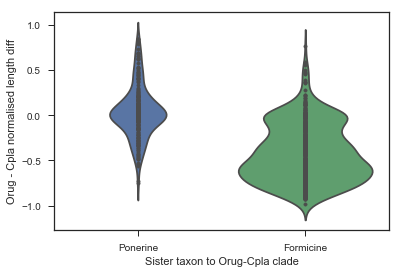

In [43]:
ax9 = sns.violinplot(data = [O_con_ldiff, C_con_ldiff], scale = 'count', inner = 'point')
ax9.set(ylabel = 'Orug - Cpla normalised length diff')
ax9.set_xticklabels(['Ponerine', 'Formicine'])
ax9.set_xlabel('Sister taxon to Orug-Cpla clade')
ax9 = sns.set_style('ticks')

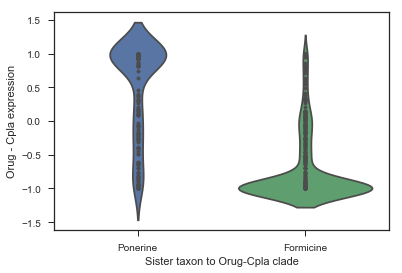

In [44]:
ax10 = sns.violinplot(data = [O_con_ediff, C_con_ediff], scale = 'count', inner = 'point')
ax10.set(ylabel = 'Orug - Cpla expression')
ax10.set_xticklabels(['Ponerine', 'Formicine'])
ax10.set_xlabel('Sister taxon to Orug-Cpla clade')
ax10 = sns.set_style('ticks')

In [45]:
cd /Users/vchandra/Desktop/alignm/biopython_test/

/Users/vchandra/Desktop/alignm/biopython_test/Orug/Orug_trees


### 6. Identify and remove contaminants from the transcriptome

In [46]:
#make list of contaminant genes that should be removed from the Orug transcriptome
#include genes if contaminated says 1 and if rfdist >= 0.6
genes_for_removal = []
count = 0
c2 = []

for ind, row in genes.iterrows():
    if row['class'] == 'Bad':
        genes_for_removal.append(row['Orug_genes'])
    elif row['ctd_sis_taxon'] != 'P' and (row['rfdist'] >= 0.6 or pd.isnull(row['rfdist'])) and (row['dist_classification'] == 1 or (row['exp_diff'] < -0.2 and row['len_diff'] < -0.2)):
        genes_for_removal.append(row['Orug_genes'])
        count += 1
    elif row['ctd_sis_taxon'] == 'F' and (row['exp_diff'] < -0.2 and row['len_diff'] < -0.2):
        genes_for_removal.append(row['Orug_genes'])
        c2.append(row['Orug_genes'])
print(len(genes_for_removal), count, len(c2))

(703, 332, 91)


In [47]:
clean_Orug_txome = {}

for key in Orug_txome.keys():
    if key not in genes_for_removal:
        clean_Orug_txome[key] = Orug_txome[key]

In [48]:
print(len(Orug_txome))
print(len(clean_Orug_txome))

26161
25458


In [34]:
#WRITE NEW ORUG TRANSCRIPTOME
with open('clean_Orug_txome.fasta', 'a') as f:
    for key in clean_Orug_txome.keys():
        f.write('>' + key + '\n' + clean_Orug_txome[key] + '\n')
    f.close()
    

### 7. Remove contaminant sequences from the Orug htseq counts files

In [50]:
cd /Users/vchandra/Desktop/Orug_Cpla_DESeq/

/Users/vchandra/Desktop/Orug_Cpla_DESeq


In [51]:
#list htseq count files
Orug_list = []
for file in os.listdir('Orug/'):
    if 'Orug' in file:
        Orug_list.append(file)

In [52]:
cd Orug/

/Users/vchandra/Desktop/Orug_Cpla_DESeq/Orug


In [567]:
for sample in Orug_list:
    fdic = {}
    bad_list = []
    fout = {}
    
    f = pd.read_table(sample, sep = '\t', header = None)
    for ind, row in f.iterrows():
        fdic[row[0]] = row[1]
    
    for key in fdic.keys():
        if 'SGF' in key and key not in clean_Orug_txome.keys():
            bad_list.append(key)
        else:
            fout[key] = fdic[key]

#WRITE TO NEW HTSEQ COUNTS FILE              
#    with open(sample + (str('.clean.txt')), 'a') as i:
#        for key in fout.keys():
#            i.write(str(key) + str('\t') + str(fout[key]) + str('\n'))
#        i.close()

            
